In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import optimizers, backend, callbacks
import tensorflow.keras.utils as np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Lectura del archivo de imágenes
dataset = pd.read_csv('/content/drive/MyDrive/SenasDataset.csv', header= None)

In [4]:
# Tamaño de los datos
dataset.shape

(12000, 1601)

**Preprocesamiento**

In [5]:
# Cambio del tipo de dato del data set a arreglo de numpy
dataset = dataset.values

In [6]:
# Separar imágenes y etiquetas
imagenes = dataset[:, :-1]
clases = dataset[:, -1] #clases = dataset[:, 1600]

In [7]:
# Verificar las clases antes de codificarlas
print(np.unique(clases))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


In [8]:
# Transformar imágenes a su formato original
imagenes = imagenes.reshape(12000, 40, 40, 1)

In [9]:
# Normalizar las imágenes
imagenes = imagenes/255

In [10]:
# Codificación one-hot de las clases
etiquetas = to_categorical(clases, num_classes=24)

# Mostrar la codificación one-hot
print(clases[0], '->', etiquetas[0])

0.0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


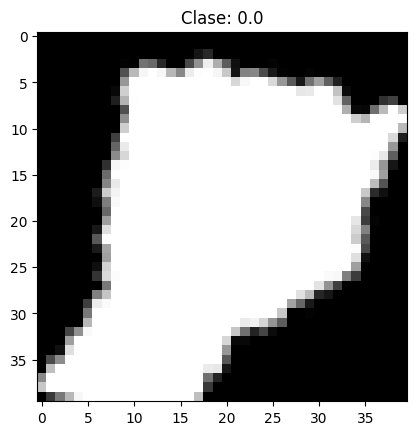

In [11]:
# Visualización
plt.imshow(imagenes[0].reshape(40, 40), cmap='gray')
plt.title(f'Clase: {clases[0]}')
plt.show()

In [12]:
# 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)

# 80% entrenamiento y 20% validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [13]:
print("Conjunto de entrenamiento:", X_train.shape)
print("Conjunto de validación:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)

Conjunto de entrenamiento: (7680, 40, 40, 1)
Conjunto de validación: (1920, 40, 40, 1)
Conjunto de prueba: (2400, 40, 40, 1)


**Modelo**

In [14]:
backend.clear_session()

In [22]:
# Construcción del modelo
modelo = Sequential()
modelo.add(Conv2D(16, kernel_size=(3,3), activation='gelu', input_shape=(40, 40, 1)))
modelo.add(MaxPooling2D(pool_size=(2,2)))

modelo.add(Conv2D(32, kernel_size=(3,3), activation='gelu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

modelo.add(Conv2D(64, kernel_size=(3,3), activation='gelu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.3))

modelo.add(Flatten())

modelo.add(Dense(50, activation='gelu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(30, activation='relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(24, activation='softmax'))

In [23]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Optimizador y compilación del modelo
adam = optimizers.Adam(learning_rate=0.001)
modelo.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
#Checkpointer para guardar el mejor modelo
checkpointer = callbacks.ModelCheckpoint('lenguajeSenas.keras', monitor = 'val_accuracy', save_best_only = True,
                                         mode = 'max')

In [25]:
# Entrenamiento del modelo
M = modelo.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=90, batch_size=64,
               callbacks=[checkpointer], verbose=True)

Epoch 1/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.0451 - loss: 3.1644 - val_accuracy: 0.1281 - val_loss: 2.8821
Epoch 2/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.1302 - loss: 2.8052 - val_accuracy: 0.2344 - val_loss: 2.3369
Epoch 3/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.2095 - loss: 2.4345 - val_accuracy: 0.3146 - val_loss: 2.0845
Epoch 4/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.2544 - loss: 2.2318 - val_accuracy: 0.4078 - val_loss: 1.8361
Epoch 5/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.3408 - loss: 1.9567 - val_accuracy: 0.5161 - val_loss: 1.5297
Epoch 6/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.3777 - loss: 1.7967 - val_accuracy: 0.5427 - val_loss: 1.3963
Epoch 7/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.4184 - loss: 1.6547 - val_accuracy: 0.5745 - val_loss: 1.2453
Epoch 8/90
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.4743 - loss: 1

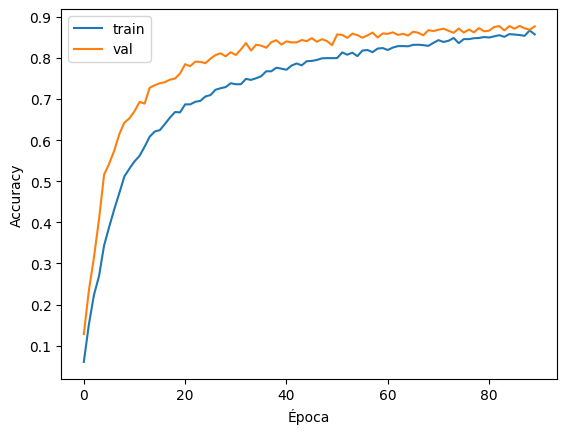

In [26]:
# Evaluación del modelo
plt.plot(M.history['accuracy'], label = 'train')
plt.plot(M.history['val_accuracy'], label = 'val')
plt.legend(loc = 'best')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.show()

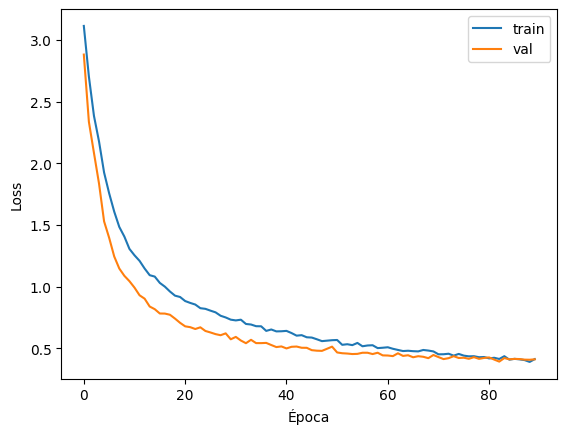

In [27]:
# Evaluación del modelo
plt.plot(M.history['loss'], label = 'train')
plt.plot(M.history['val_loss'], label = 'val')
plt.legend(loc = 'best')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.show()

In [28]:
# Evaluación general del modelo en el conjunto de prueba
loss, accuracy = modelo.evaluate(X_test, y_test, verbose=0)
print(f'Loss en prueba: {loss:.4f}')
print(f'Accuracy en prueba: {accuracy:.4f}')

Loss en prueba: 0.4524
Accuracy en prueba: 0.8721


**Prueba del modelo**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


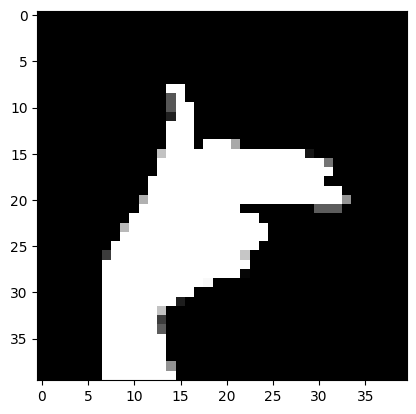

predicción =  7
real = 7


In [ ]:
n_imagen = 50
prediccion = modelo.predict(X_test[n_imagen].reshape(1,40,40,1))

plt.imshow(X_test[n_imagen].reshape(40,40), cmap='gray')
plt.show()

print('predicción = ', np.argmax(prediccion))
print('real =', np.argmax(y_test[n_imagen]))